In [7]:
!pip install pyvista
!python -m pip install petsc petsc4py
!pip install numpy
!pip install dolfinx
!pip install ufl
#Build Dolfinx



ERROR: Could not find a version that satisfies the requirement dolfinx (from versions: none)
ERROR: No matching distribution found for dolfinx
CMake Warning:
  Ignoring extra path from command line:

   ".."


CMake Error: The source directory "/" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.
make: *** No rule to make target 'install'.  Stop.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'build-requirements.txt'
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [6]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista as pv
from pyvista import examples

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc, LinearProblem, NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square, CellType
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym, grad)
import numpy as np

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'dolfinx'

In [ ]:
X_POINTS = 50
Y_POINTS = 50
mesh = create_unit_square(MPI.COMM_WORLD, X_POINTS, Y_POINTS, CellType.quadrilateral)

err=1e-8

**References**
```{bibliography}
:filter: docname in docnames
```

In [ ]:
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
v_func_space = functionspace(mesh, v_cg2)
rho_func_space = functionspace(mesh, s_cg1)

In [ ]:
u_trial = TrialFunction(v_func_space)
v_test = TestFunction(v_func_space)
p_trial = TrialFunction(rho_func_space)
q_test = TestFunction(rho_func_space)

In [ ]:
#Boundry Conditions

def on_boundry(point):
  return np.allclose(point, (0.0, point[1]), rtol=err) or np.allclose(point, (1.0, point[1])) or np.allclose(point, (point[0], 0.0)) or np.allclose(point, (point[0], 1.0))
# Locate degrees of freedoon the boundary
"""
dofs1 = locate_dofs_geometrical(v_func_space, on_left_boundary)
val = Constant(mesh, PETSc.ScalarType((1.0, 0.0)))
left_bc = dirichletbc(val, dofs1, v_func_space)

dofs2 = locate_dofs_geometrical(v_func_space, lower_boundry)
val2 = Constant(mesh, PETSc.ScalarType((0.0, 0.0)))
lower_bc = dirichletbc(val2, dofs2, v_func_space)

dofs3 = locate_dofs_geometrical(v_func_space, upper_boundry)
val3 = Constant(mesh, PETSc.ScalarType((0.0, 0.0)))
higher_bc = dirichletbc(val3, dofs3, v_func_space)
velocity_boundry_conditions = [left_bc, lower_bc, higher_bc]
"""

In [ ]:
"""
u: velocity field prev
u*: velocity field after tentative momentum step
u**: velocity field after incompressability step
rho*: pressure field after next time step
delta_t: time step
v: function space of velocity
q: function space of density

solve for u*
0 = 1/(delta_t) * <(u* - u), v> + <(grad(u))u, v> + <grad(u*), grad(v)>

solve for p*
<grad(rho*), grad(q)> = 1/(delta_t) <grad(u*), q>

solve for u**
<u**, v> = <u*, v> - 1/(delta_t) * <grad(rho*), v>
"""

'\nu: velocity field prev\nu*: velocity field after tentative momentum step\nu**: velocity field after incompressability step\nrho*: pressure field after next time step\ndelta_t: time step\nv: function space of velocity\nq: function space of density\n\nsolve for u*\n0 = 1/(delta_t) * <(u* - u), v> + <(grad(u))u, v> + <grad(u*), grad(v)>\n\nsolve for p*\n<grad(rho*), grad(q)> = 1/(delta_t) <grad(u*), q>\n\nsolve for u**\n<u**, v> = <u*, v> - 1/(delta_t) * <grad(rho*), v>\n'

In [ ]:
u_prev = Function(v_func_space)
u_tent = Function(v_func_space)
u_next = Function(v_func_space)
p_next = Function(rho_func_space)

In [ ]:
"""
Get Equations Here
"""

'\nGet Equations Here\n'

In [ ]:
#time steps loop

In [ ]:
#Prepare mesh for visualization
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)

"""
Just gets mesh
"""
cells, cell_types, points = vtk_mesh(mesh, mesh.topology.dim)
for i in range(len(cell_types)):
    cell_types[i]=9
grid = pv.UnstructuredGrid(cells, cell_types, points)

curve_data = []
for x in range(X_POINTS+1):
    for y in range(Y_POINTS+1):
        val1 = (x/(X_POINTS+1))**2
        val2 = (1 - ((x/(X_POINTS+1))))**2
        curve_data.append(np.sqrt(val1 + val2))

grid.point_data["curves"] = np.array(curve_data)
grid.set_active_scalars("curves")

warped = grid.warp_by_scalar("curves")

In [ ]:
# Define 3D grid points
x_vals = np.linspace(0, 1, X_POINTS)
y_vals = np.linspace(0, 1, Y_POINTS)

z_vals = np.array(curve_data)
x, y, z = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')

#Flatten For x,y,z

x_flat = x.ravel()
y_flat = y.ravel()
z_flat = z.ravel()

#F(x, y, z) = (u, v, w) where u,v,w = Combination(x_flat, y_flat, z_flat, +, -, * /)
u = x_flat
v = y_flat
w = z_flat

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (4099083909.py, line 5)

In [ ]:
# Stack point coordinates
points = np.stack((x_flat, y_flat, z_flat), axis=1)

# Create a PyVista point cloud
point_cloud = pv.PolyData(points)
#for variable vectors
vectors = np.stack((u, v, w), axis=1)
#for const
#vectors = np.tile([1, 1, 0], (len(u), 1))
point_cloud["vectors"] = vectors  # Attach vector data Use glyphs to create arrows representing the vector field
arrows = point_cloud.glyph(orient="vectors", scale="vectors", factor=0.05)

In [ ]:
# Plot
pv.start_xvfb()  # Starts a virtual framebuffer if needed
plotter = pv.Plotter(off_screen=True)

added_mesh = plotter.add_mesh(arrows)

manifold = plotter.add_mesh(warped, cmap = "terrain", edge_color="#000000", show_edges=True, show_scalar_bar=True)
pic = plotter.screenshot("manifold.png")  # Save to image file


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


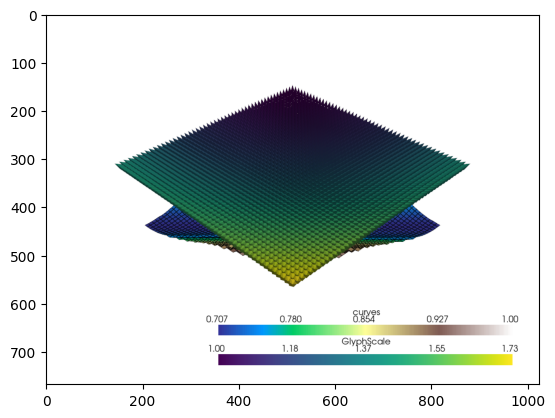

In [ ]:
plt.imshow(plotter.image)
plt.show()